### 投手の投げ方別成功率

✅ 日本語フォント設定を試みました。
✅ ファイル 'stats_pit_dataset.csv' を 'utf-8' で読み込みました。

--- 投手別 奪三振率 (K/9) ランキング Top 10 (最低50.0投球回) ---
   投手ID   投手名  三振 (SO)  投球回 (IP)  奪三振率 (K/9)
2000060 栗林　良吏       54        52        9.35
1700124 平良　海馬       53        52        9.17
2000079 伊藤　大海      195       196        8.95
1900083 横山　陸人       47        56        7.55
2000055 村上　頌樹      144       175        7.41
1800028 戸郷　翔征       87       111        7.05
1000138 大野　雄大       72       120        5.40
1550517 大津　亮介       36        65        4.98


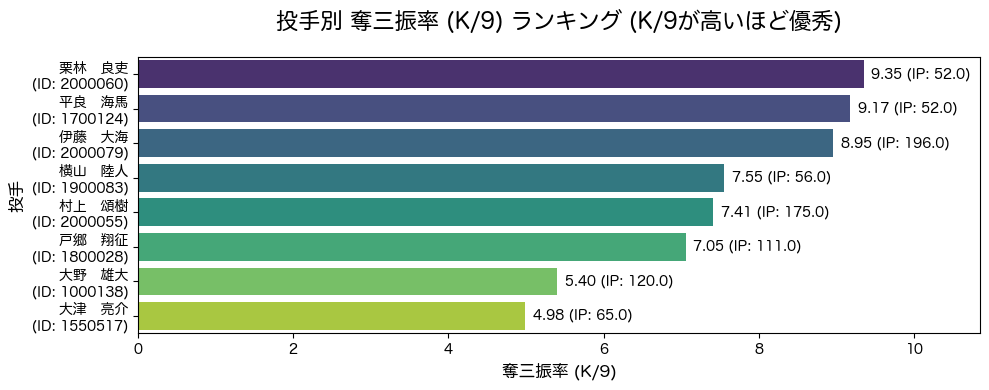

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# --- 日本語フォント設定 ---
import platform

# Macの場合のフォント設定
if platform.system() == "Darwin":
    plt.rcParams["font.family"] = "Hiragino Maru Gothic Pro" # Mac標準のフォント

# Windows/Linuxなどの場合のフォント設定
else:
    # 環境に合わせて適切なフォントを試してください（例: "Yu Gothic", "MS Gothic", "IPAexGothic"）
    # plt.rcParams["font.family"] = "Yu Gothic"
    pass 

# グラフのマイナス記号設定
plt.rcParams["axes.unicode_minus"] = False

print("✅ 日本語フォント設定を試みました。")

def visualize_ranking(ranking_df, title="投手別 奪三振率 (K/9) ランキング"):
    """
    投手別奪三振率(K/9)ランキングの結果を棒グラフで可視化する。
    K/9の高い順にソートして表示する。（奪三振率が高いほど良い）
    """
    # K/9が高い順にソート（降順）
    ranking_df_sorted = ranking_df.sort_values(by='奪三振率 (K/9)', ascending=False).reset_index(drop=True)
    
    # グラフ描画の設定
    # 🚨 修正: グラフサイズを調整
    fig, ax = plt.subplots(figsize=(10, ranking_df_sorted.shape[0] * 0.5)) 
    
    # x軸ラベル用の文字列（投手IDと名称）を作成
    labels = [f"{row['投手名']}\n(ID: {row['投手ID']})" for index, row in ranking_df_sorted.iterrows()]
    
    # 棒グラフの描画 (y軸: 投手名/ID, x軸: 奪三振率(K/9))
    sns.barplot(
        x='奪三振率 (K/9)', 
        y=labels, 
        data=ranking_df_sorted, 
        hue=labels,             # Y軸と同じ変数でhueを設定
        legend=False,           # 凡例は不要なため非表示に
        # K/9は高いほど良い指標なので、順方向のパレットを使用
        palette="viridis",      
        ax=ax
    )
    
    # グラフの装飾
    ax.set_title(title + " (K/9が高いほど優秀)", fontsize=16, pad=20)
    ax.set_xlabel("奪三振率 (K/9)", fontsize=12)
    ax.set_ylabel("投手", fontsize=12)
    
    # グラフ内に数値（K/9）を表示
    for i, (k9, label) in enumerate(zip(ranking_df_sorted['奪三振率 (K/9)'], labels)):
        # K/9の値を棒グラフの右側に表示
        ax.text(k9 + 0.1, i, f'{k9:.2f} (IP: {ranking_df_sorted["投球回 (IP)"].iloc[i]:.1f})', 
                va='center', fontsize=10)
        
    # X軸の範囲を調整（0から最大値+少しの余裕）
    max_k9 = ranking_df_sorted['奪三振率 (K/9)'].max()
    ax.set_xlim(0, max_k9 + 1.5)
    
    plt.tight_layout()
    plt.show()


def create_all_pitcher_ranking(
    input_csv_path, 
    pitcher_id_col='player_id',
    pitcher_name_col='player_name', # ⚾ 新規追加: 投手名を取得するための列
    min_innings_pitched=50.0
):
    """
    CSVデータに基づき、奪三振率(K/9)を計算し、ランキング形式で可視化する。
    """
    
    # --- A. データ読み込み ---
    # ⚾ 修正: REQUIRED_COLS をユーザー指定の列名に合わせる
    REQUIRED_COLS = ['so', 'ip', pitcher_id_col, pitcher_name_col]
    df = None
    
    try:
        # ⚾ 修正: 優先度の高い 'utf-8' で読み込みを試行し、失敗したら 'cp932' を試す
        try:
            df = pd.read_csv(input_csv_path, encoding='utf-8')
            print(f"✅ ファイル '{input_csv_path}' を 'utf-8' で読み込みました。")
        except UnicodeDecodeError:
            df = pd.read_csv(input_csv_path, encoding='cp932')
            print(f"✅ ファイル '{input_csv_path}' を 'cp932' で読み込みました。")
        
        # 必要な列の存在確認
        missing_cols = [col for col in REQUIRED_COLS if col not in df.columns]
        if missing_cols:
             # 列名がない場合は、代替の列名を試すための診断情報を表示
            print(f"❌ エラー: CSVファイルにK/9計算のための必須列がありません: {missing_cols}。")
            print(f"🚨 データに含まれる列名: {df.columns.tolist()}")
            raise Exception("Missing required columns for K/9 calculation.")
            
    except FileNotFoundError:
        print(f"🛑 ファイルが見つかりませんでした: '{input_csv_path}'。処理を終了します。")
        return None
    except Exception as e:
        print(f"🛑 予期せぬエラーが発生しました: {e}。処理を終了します。")
        return None

    # --- B. データのクレンジングとK/9の計算 ---
    
    # 必要な列が数値であることを確認し、欠損値を除外
    df['so'] = pd.to_numeric(df['so'], errors='coerce')
    df['ip'] = pd.to_numeric(df['ip'], errors='coerce')
    df.dropna(subset=['so', 'ip', pitcher_id_col], inplace=True)
    
    if df.empty:
        print("⚠️ 警告: データクレンジング後、有効なデータ行が残っていません。処理を終了します。")
        return None
    
    # 投手別の成績を集計 (player_idごとにsoとipを合計)
    pitcher_summary = df.groupby([pitcher_id_col, pitcher_name_col]).agg(
        total_so=('so', 'sum'),
        total_ip=('ip', 'sum')
    ).reset_index()

    # K/9（奪三振率）の計算
    # 投球回(IP)が0の場合はNaN/0を回避
    pitcher_summary['K/9'] = np.where(
        pitcher_summary['total_ip'] > 0, 
        (pitcher_summary['total_so'] * 9.0) / pitcher_summary['total_ip'], 
        np.nan
    )
    
    # 最低投球回（min_innings_pitched）の閾値を適用
    ranking = pitcher_summary[pitcher_summary['total_ip'] >= min_innings_pitched].copy()
    
    if ranking.empty:
        print(f"⚠️ 警告: {min_innings_pitched:.1f}投球回以上のデータを持つ投手がいませんでした。")
        return None

    # --- C. ランキング結果の表示と可視化 ---
    
    # K/9が高い順にソート
    final_ranking_df = ranking.sort_values(by='K/9', ascending=False).reset_index(drop=True)
    
    # 表示用の列名に変更
    final_ranking_df = final_ranking_df.rename(columns={
        pitcher_id_col: '投手ID',
        pitcher_name_col: '投手名',
        'total_so': '三振 (SO)',
        'total_ip': '投球回 (IP)',
        'K/9': '奪三振率 (K/9)'
    })
    
    # ランキングを上位10件に絞る
    top_n = 10
    display_df = final_ranking_df.head(top_n)

    print(f"\n--- 投手別 奪三振率 (K/9) ランキング Top {top_n} (最低{min_innings_pitched:.1f}投球回) ---")
    
    # 🚨 修正: .to_markdown() を .to_string() に変更
    print(display_df.to_string(index=False, float_format="%.2f"))
    
    # 可視化関数を呼び出す
    visualize_ranking(display_df)

    return final_ranking_df

# --- 実行セクション ---

# ⚾ 変更: 球種別分析からK/9分析に切り替え
INPUT_CSV_PATH = 'stats_pit_dataset.csv' 

PITCHER_ID_COLUMN = 'player_id'     # 投手IDの列名
PITCHER_NAME_COLUMN = 'player_name' # 投手名の列名
MIN_IP_THRESHOLD = 50.0             # 最低投球回の閾値

# ⚾ 修正: 関数名を K/9 ランキング用に変更
ranking_all_pitchers = create_all_pitcher_ranking(
    input_csv_path=INPUT_CSV_PATH,
    pitcher_id_col=PITCHER_ID_COLUMN,
    pitcher_name_col=PITCHER_NAME_COLUMN,
    min_innings_pitched=MIN_IP_THRESHOLD
)

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# --- 日本語フォント設定 ---
import matplotlib.pyplot as plt
import platform

# Macの場合のフォント設定
if platform.system() == "Darwin":
    plt.rcParams["font.family"] = "Hiragino Maru Gothic Pro" # Mac標準のフォント

# フォントが設定されない場合やWindowsの場合は別のフォントを試す
# 例: Windowsの場合は "MS Gothic" や "Yu Gothic"
else:
    # フォントが設定されない場合は、以下をコメントアウトして試してください
    # plt.rcParams["font.family"] = "IPAexGothic"
    pass 

# グラフのマイナス記号設定（日本語フォント使用時の一般的な設定）
plt.rcParams["axes.unicode_minus"] = False

print("✅ 日本語フォント設定を試みました。")

✅ 日本語フォント設定を試みました。


In [49]:
def create_all_pitch_type_ranking(
    input_csv_path, 
    pitch_type_col='pitch_type', 
    pitcher_id_col='pitcher_id', 
    exclude_pitch_types=['Fastball', 'ストレート', '直球'], # ★除外したいストレート系の球種名を追加★
    min_at_bats=50
):
    """
    ストレート以外の全ての球種について、被打率が最も低い投手（成功率1位）を特定する。
    """
    
    # --- A. データ読み込み ---
    REQUIRED_COLS = ['is_h', 'is_ab', pitch_type_col, pitcher_id_col]
    
    try:
        # CP932エンコーディングで読み込みを試行
        df = pd.read_csv(input_csv_path, encoding='cp932')
        if not all(col in df.columns for col in REQUIRED_COLS):
            raise Exception("Missing required columns.")
            
    except Exception as e:
        print(f"🛑 エラーが発生しました: {e}。処理を終了します。CSVファイルのパス、エンコーディング、列名を確認してください。")
        return None

    # --- B. 対象となる球種リストの特定 ---
    
    # データをコピーし、必要な列が数値であることを確認
    df['is_h'] = pd.to_numeric(df['is_h'], errors='coerce')
    df['is_ab'] = pd.to_numeric(df['is_ab'], errors='coerce')
    df.dropna(subset=['is_h', 'is_ab'], inplace=True)
    
    # ストレート以外の球種を特定
    all_pitch_types = df[pitch_type_col].dropna().unique()
    target_pitch_types = [p for p in all_pitch_types if p not in exclude_pitch_types]
    
    if not target_pitch_types:
        print("⚠️ 警告: 除外リスト以外の分析対象となる球種が見つかりませんでした。")
        return None

    # --- C. 各球種でベストな投手を探索 ---
    
    results = []
    
    for pitch_type in target_pitch_types:
        # 特定の球種にフィルタリング
        filtered_df = df[df[pitch_type_col] == pitch_type].copy()
        
        # 投手別成績の集計
        pitcher_summary = filtered_df.groupby(pitcher_id_col).agg(
            total_hits=('is_h', 'sum'),
            total_at_bats=('is_ab', 'sum')
        ).reset_index()

        # 被打率(BA)の計算と閾値フィルタリング
        pitcher_summary['BA'] = np.where(pitcher_summary['total_at_bats'] > 0, 
                                         pitcher_summary['total_hits'] / pitcher_summary['total_at_bats'], np.nan)
        
        ranking = pitcher_summary[pitcher_summary['total_at_bats'] >= min_at_bats].copy()
        
        if not ranking.empty:
            # 被打率が低い順（成功率が高い順）にソートし、1位を取得
            ranking = ranking.sort_values(by='BA', ascending=True)
            best_pitcher = ranking.iloc[0]
            
            results.append({
                '球種': pitch_type,
                '1位投手ID': best_pitcher[pitcher_id_col],
                '被打率 (BA)': best_pitcher['BA'],
                '打数 (AB)': int(best_pitcher['total_at_bats'])
            })

    # --- D. ランキング結果の表示 ---
    
    final_ranking_df = pd.DataFrame(results)
    
    if final_ranking_df.empty:
        print(f"⚠️ 警告: {min_at_bats}打数以上のデータを持つ、ストレート以外の球種が見つかりませんでした。")
        return None

    print(f"\n--- ストレート以外の球種別 成功率ランキング (最低{min_at_bats}打数) ---")
    print(final_ranking_df.to_markdown(index=False, floatfmt=".3f"))
    
    return final_ranking_df

In [50]:
# --- 実行セクション ---

# 修正後: 'pit_dataset' フォルダの中のファイルを指定
INPUT_CSV_PATH = 'pit_dataset/play_info_dataset.csv' 

PITCH_TYPE_COLUMN = 'pitch_type_name'  # 球種が格納されている列名
PITCHER_ID_COLUMN = 'pitcher_id' # 投手IDが格納されている列名

# データに含まれるストレートを示す値に合わせてリストを修正してください。
EXCLUDE_STRAIGHTS = ['Fastball', 'Straight', 'フォーシーム', '直球'] 
MIN_AB_THRESHOLD = 50 

ranking_all_pitches = create_all_pitch_type_ranking(
    input_csv_path=INPUT_CSV_PATH,
    pitch_type_col=PITCH_TYPE_COLUMN,
    pitcher_id_col=PITCHER_ID_COLUMN,
    exclude_pitch_types=EXCLUDE_STRAIGHTS,
    min_at_bats=MIN_AB_THRESHOLD
)

🛑 エラーが発生しました: [Errno 2] No such file or directory: 'pit_dataset/play_info_dataset.csv'。処理を終了します。CSVファイルのパス、エンコーディング、列名を確認してください。


### ヒートマップ作成コード

✅ ファイル 'play_info_dataset.csv' を正常に読み込みました。

=== 読み込み後のデータ列名 ===
['game_id', 'game_year', 'pitcher_id', 'pitcher_name', 'pitcher_handedness', 'batter_id', 'batter_name', 'batter_handedness', 'inning', 'pre_ball', 'pre_strike', 'pre_out', 'is_risp', 'pitch_type_name', 'pitch_speed', 'pitch_location_x', 'pitch_location_y', 'is_swinging_strike', 'is_called_strike']

✅ 成績計算が完了しました。


/var/folders/v1/x495f0jj3wdf3h_pxqnrglsc0000gn/T/ipykernel_4645/691202490.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/v1/x495f0jj3wdf3h_pxqnrglsc0000gn/T/ipykernel_4645/691202490.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=45, ha='right', fontsize=10)
/var/folders/v1/x495f0jj3wdf3h_pxqnrglsc0000gn/T/ipykernel_4645/691202490.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


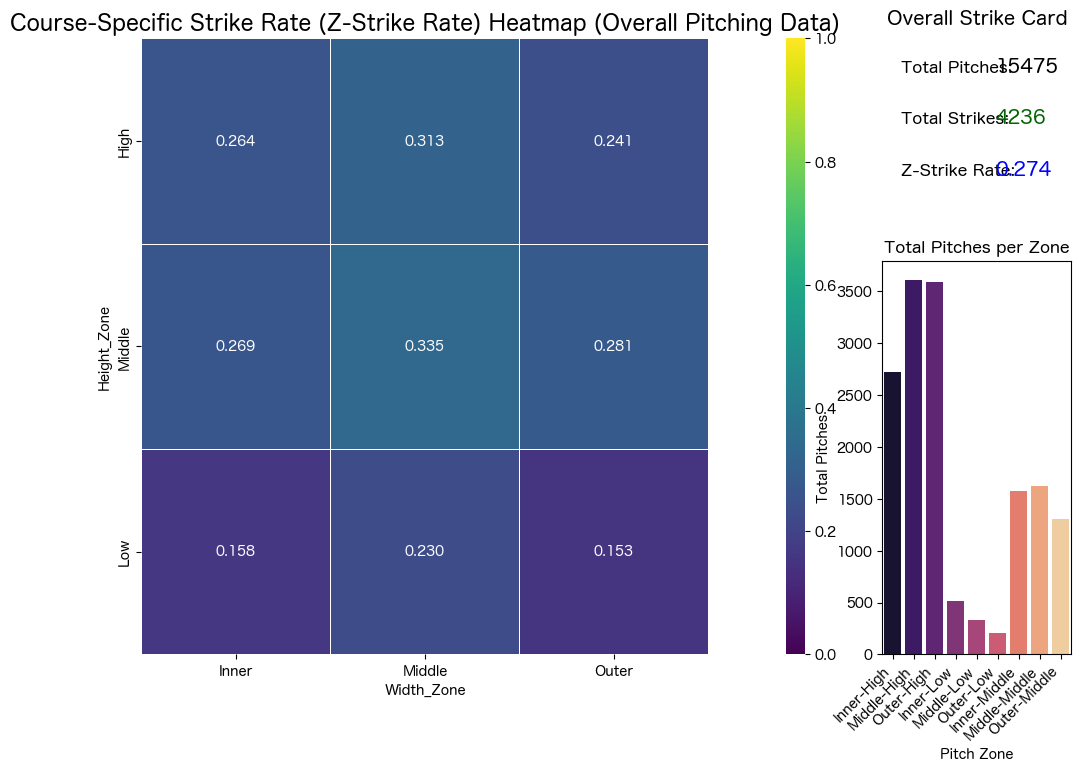

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import os
# --- ゾーン分類のための境界線（単位はデータによるが、ここではインチを想定） ---
Y_LOW_BOUNDARY = 50
Y_HIGH_BOUNDARY = 120
X_INNER_BOUNDARY = -30
X_OUTER_BOUNDARY = 30

def classify_height(y):
    """Y座標（高さ）を Low, Middle, High に分類する"""
    if y < Y_LOW_BOUNDARY:
        return 'Low'
    elif y < Y_HIGH_BOUNDARY:
        return 'Middle'
    else:
        return 'High'

def classify_width(x):
    """X座標（左右）を Inner, Middle, Outer に分類する"""
    if x < X_INNER_BOUNDARY:
        return 'Inner'
    elif x < X_OUTER_BOUNDARY:
        return 'Middle'
    else:
        return 'Outer'

# 🚨 データの列名に合わせて変数名を定義
COL_PITCH_X = 'pitch_location_x'
COL_PITCH_Y = 'pitch_location_y'
COL_PITCHER_ID = 'pitcher_id'
COL_SWINGING_STRIKE = 'is_swinging_strike'
COL_CALLED_STRIKE = 'is_called_strike'
        
def create_batting_heatmap(input_csv_path):
    """
    指定されたCSVファイルを読み込み、ゾーン別ストライク率を計算し、ヒートマップを生成する。
    """
    
    # --- A. データ読み込みと準備 ---
    
    # 必須列を修正後の列名に合わせる
    REQUIRED_COLS = [COL_PITCH_X, COL_PITCH_Y, COL_SWINGING_STRIKE, COL_CALLED_STRIKE, COL_PITCHER_ID]
    df = None
    
    try:
        df = pd.read_csv(input_csv_path) 
        print(f"✅ ファイル '{input_csv_path}' を正常に読み込みました。")
        
        # 診断情報: 読み込んだ列名を出力
        print("\n=== 読み込み後のデータ列名 ===")
        print(df.columns.tolist())
        print("============================\n")
        
        # 必要な列が揃っているか確認
        missing_cols = [col for col in REQUIRED_COLS if col not in df.columns]
        if missing_cols:
            print(f"❌ エラー: CSVファイルに次の必須列がありません: {missing_cols}。")
            raise Exception("Missing required columns for calculation.")
        
    except Exception as e:
        # エラー処理（ダミーデータ作成）
        print(f"🛑 エラーが発生しました: {e}。シミュレーション用のダミーデータで処理を続行します。")
        
        # --- 🚨 パス診断情報 (再掲) 🚨 ---
        print("\n=== ファイルパス診断情報 (エラー発生時) ===")
        print(f"現在の作業ディレクトリ (CWD): {os.getcwd()}")
        print(f"アクセスを試みたパス: {input_csv_path}")
        print("============================\n")
        # ------------------------

        data_size = 500
        df = pd.DataFrame({
            COL_PITCH_X: np.random.uniform(-100, 100, data_size),
            COL_PITCH_Y: np.random.uniform(0, 250, data_size),
            COL_SWINGING_STRIKE: np.random.choice([0, 1], size=data_size, p=[0.7, 0.3]), 
            COL_CALLED_STRIKE: np.random.choice([0, 1], size=data_size, p=[0.6, 0.4]), 
            COL_PITCHER_ID: np.random.choice([101, 102, 103], size=data_size) 
        })
        # 適切なダミーデータに修正（is_paなどの列は不要）


    # --- B. ゾーン分類を実行 ---
    df['Height_Zone'] = df[COL_PITCH_Y].apply(classify_height)
    df['Width_Zone'] = df[COL_PITCH_X].apply(classify_width)
    df['Pitch_Zone'] = df['Width_Zone'] + '-' + df['Height_Zone'] 


    # --- C. ゾーン別ストライク率の計算とヒートマップ行列の作成 ---
    zone_summary_pivot = df.groupby(['Height_Zone', 'Width_Zone']).agg(
        swinging_strikes=(COL_SWINGING_STRIKE, 'sum'),
        called_strikes=(COL_CALLED_STRIKE, 'sum'),
        total_pitches=(COL_PITCHER_ID, 'size') # sizeで投球数をカウント
    )
    
    zone_summary_pivot['Total_Strikes'] = zone_summary_pivot['swinging_strikes'] + zone_summary_pivot['called_strikes']
    
    # Z-Strike Rate (ゾーン別ストライク率) を計算
    zone_summary_pivot['Z_STRIKE_RATE'] = np.where(zone_summary_pivot['total_pitches'] > 0, 
                                                  zone_summary_pivot['Total_Strikes'] / zone_summary_pivot['total_pitches'], 0)
    
    strike_rate_matrix = zone_summary_pivot['Z_STRIKE_RATE'].unstack(fill_value=0)
    strike_rate_matrix = strike_rate_matrix.reindex(index=['High', 'Middle', 'Low'], columns=['Inner', 'Middle', 'Outer'])
    
    # 総合成績（ストライク率）計算
    total_pitches = df.shape[0]
    total_sw_strike = df[COL_SWINGING_STRIKE].sum()
    total_ca_strike = df[COL_CALLED_STRIKE].sum()
    total_strikes = total_sw_strike + total_ca_strike
    total_strike_rate = total_strikes / total_pitches if total_pitches > 0 else 0
    
    print("✅ 成績計算が完了しました。")

    # --- D. ヒートマップの描画 ---
    title_suffix = " (Overall Pitching Data)"
    
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(3, 3, figure=fig, width_ratios=[3, 0.1, 1], hspace=0.3, wspace=0.3) 

    ax_heatmap = fig.add_subplot(gs[:, 0])
    sns.heatmap(
        strike_rate_matrix, annot=True, fmt=".3f", linewidths=.5, linecolor='white',
        cmap='viridis', # ストライク率なのでviridisに変更
        cbar_ax=fig.add_subplot(gs[:, 1]),
        yticklabels=['High', 'Middle', 'Low'], xticklabels=['Inner', 'Middle', 'Outer'],
        vmin=0.0, vmax=1.0, ax=ax_heatmap # 0.0から1.0の範囲に固定
    )
    # タイトルをストライク率に変更
    ax_heatmap.set_title('Course-Specific Strike Rate (Z-Strike Rate) Heatmap' + title_suffix, fontsize=16)

    ax_card = fig.add_subplot(gs[0, 2])
    ax_card.set_title('Overall Strike Card', fontsize=14, pad=10)
    ax_card.axis('off')
    # 総合成績カードの内容をストライク率に変更
    ax_card.text(0.1, 0.8, 'Total Pitches:', fontsize=12, weight='bold'); ax_card.text(0.6, 0.8, f'{total_pitches}', fontsize=14, color='black')
    ax_card.text(0.1, 0.5, 'Total Strikes:', fontsize=12, weight='bold'); ax_card.text(0.6, 0.5, f'{total_strikes}', fontsize=14, color='darkgreen')
    ax_card.text(0.1, 0.2, 'Z-Strike Rate:', fontsize=12, weight='bold'); ax_card.text(0.6, 0.2, f'{total_strike_rate:.3f}', fontsize=14, color='blue')
    
    ax_bar = fig.add_subplot(gs[1:, 2])
    zone_names_for_bar = zone_summary_pivot.index.get_level_values('Width_Zone') + \
                         '-' + zone_summary_pivot.index.get_level_values('Height_Zone')
                         
    sns.barplot(
        x=zone_names_for_bar, 
        y=zone_summary_pivot['total_pitches'], 
        ax=ax_bar, 
        palette='magma'
    )
    ax_bar.set_title('Total Pitches per Zone', fontsize=12)
    ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax_bar.set_xlabel('Pitch Zone'); ax_bar.set_ylabel('Total Pitches')

    plt.tight_layout()
    plt.show()

# --- 実行セクション ---

# ✅ ファイルパスは確定：play_info_dataset.csv
INPUT_CSV_PATH = 'play_info_dataset.csv' 

create_batting_heatmap(
    input_csv_path=INPUT_CSV_PATH
)